In [1]:
# # Enable if on M1/2 mac
# import os
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
# import src.halfar_ice as hi
# from src.inference import run_inference

In [1]:
import logging
import math
import typing

import torch
from torch import tensor as tnsr
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import pyro.infer.reparam
import numpy as np

pyro.settings.set(module_local_params=True)

plt.rcParams.update({
    'font.family': 'Courier New',
    'font.size': 10,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
})

# Simulation of an Ice Dome

This notebook demonstrates the simulation of an ice dome using Halfar's approximation (1981). This affords the comparison of the numerical solution with the analytical solution and, later, a sanity check for the inference of the ice density and flow rate from noisy observations of the ice dome's height. This inference allows us to then make predictions about the dome's progression into the future.

### Comparing Analytical and Numerical Solutions

Here, we confirm that the numeric solver converges to the correct answer.

Iteration 00299/300


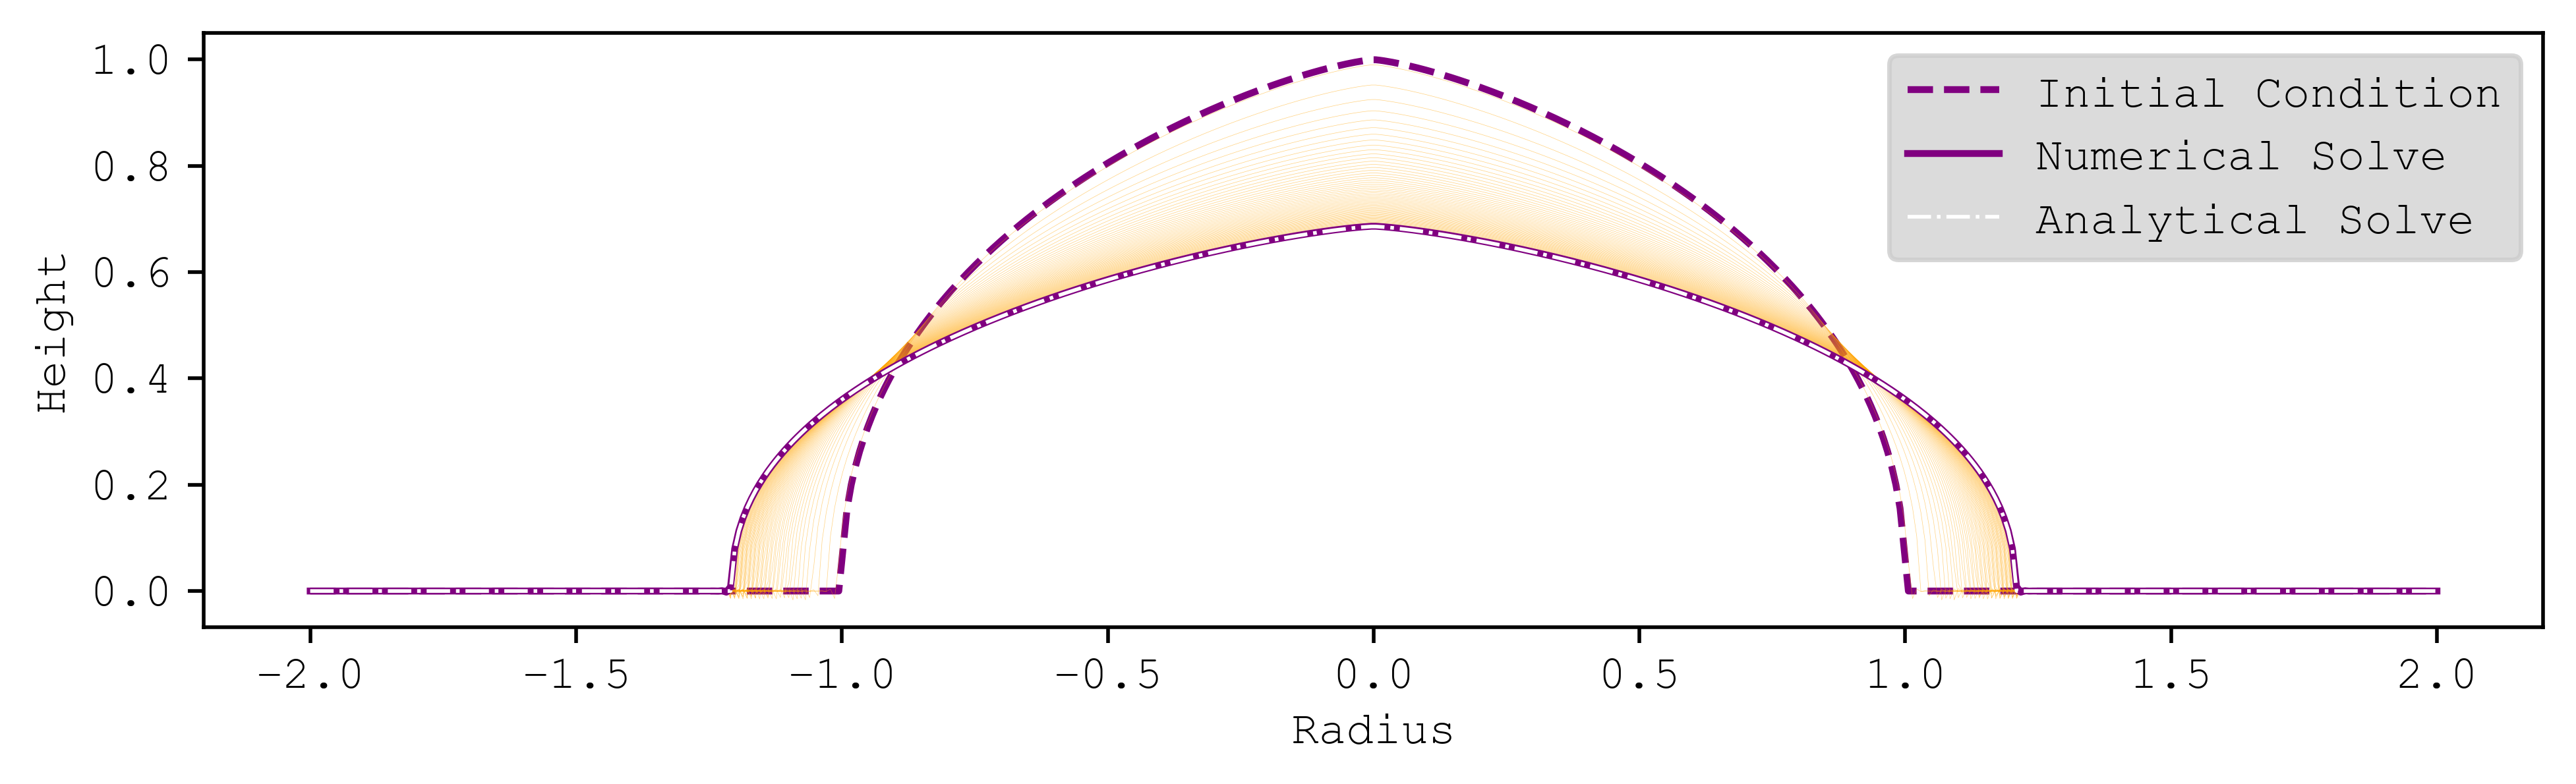

In [3]:
# Instantiate the numeric halfar ice model
num_hi_model = hi.HalfarIceNonLinearPolar(
    n_elements=511,
    solver_parameters={'newton_solver': {
        "maximum_iterations": 100,
    }}
)

# Domain will be from -2. to 2. HalfarIceNonLinearPolar uses a lagrangian FE space of degree 1, meaning
#  our solutions will have n_elements + 1 points. x here is the radius of a radially symmetric dome of ice.
space_grid = torch.linspace(-2., 2., num_hi_model.n_elements + 1).double()

# Declare some ground truth parameters affecting flow and deformation rates.
true_ice_density = tnsr(910.).double()
true_log_flow_rate = torch.log(tnsr(1e-16)).double()

# The initial height and radius of the glacier in the standard dome shape.
h0, r0 = 1., 1.

# The gamma term is a constant affecting overall flow rates.
gamma = hi.stable_gamma(rho=true_ice_density, lA=true_log_flow_rate)

t0 = 0.0

# Generate a halfar dome — with the above parameters — as the initial condition.
u_init = hi.halfar_ice_analytical(r=space_grid, t=t0, h0=h0, r0=r0, gamma=gamma)
# Massage into a shape expected by torch-fenics, and declare this as a leaf tensor for gradients.
u_init = u_init[None, :].double().clone().detach().requires_grad_(True)

# We'll employ a time stepping solution, so declare the initial condition as the last solution.
u_last_t = u_init

# Prepare a list of solutions vectors (one for each timestep).
sols = [u_last_t[0]]

# Our timestep is 1000...time units (years? days?)
tstep = tnsr(1000).double()[None, None]

# Take 300 steps of 1000...time units.
num_steps = 300
for i in range(num_steps):
    print(f"\rIteration {i:05d}/{num_steps}", end='')

    # Execute the solver and append the solution to the list.
    u_last_t = num_hi_model(tstep, u_last_t, *torch.atleast_2d(true_ice_density, true_log_flow_rate))
    sols.append(u_last_t[0])
print()

fig, ax = plt.subplots(dpi=500, figsize=(8, 4))
hi.plot_sols(space_grid, sols, ax, skip=5, final_sol_lbl="Numerical Solve", thickness1=1.5)

# Compute the analytical solution at the end (absolute) time.
analytical_end_state = hi.halfar_ice_analytical(space_grid, t=t0 + num_steps * tstep.item(), h0=h0, r0=r0, gamma=gamma)

plt.plot(space_grid, analytical_end_state, color='white', linestyle='-.',
         linewidth=0.8, label="Analytical Solve")

# Set labels.
ax.set_ylabel("Height")
ax.set_xlabel("Radius")

plt.gca().set_aspect('equal')
plt.tight_layout()
plt.legend(facecolor='lightgray')
plt.show()

In [4]:
# As an aside, both the analytical and numeric solutions operate in polar coordinates, and thus their preservation of volume
#  (due to constant density and no flux boundary conditions) can only be seen when scaling by the radius.
print(f"Glacier Mass Before == c*{(space_grid.abs() * sols[0]).sum().item()}")
print(f"Glacier Mass After == c*{(space_grid.abs() * sols[-1]).sum().item()}")

Glacier Mass Before == c*80.31409462729549
Glacier Mass After == c*80.31409415316097


### Gradients
Here, we demonstrate that gradients propagate through the numeric solver. The intuition here is that if mass is added to the left of the center, the point of interest will be higher than otherwise at the end state.

In [5]:
# Grab a point just the left of center.
poi_idx = num_hi_model.n_elements // 2 - 10

# Get gradients of the final dome height at that point.
poi = sols[-1][poi_idx]
poi.backward()

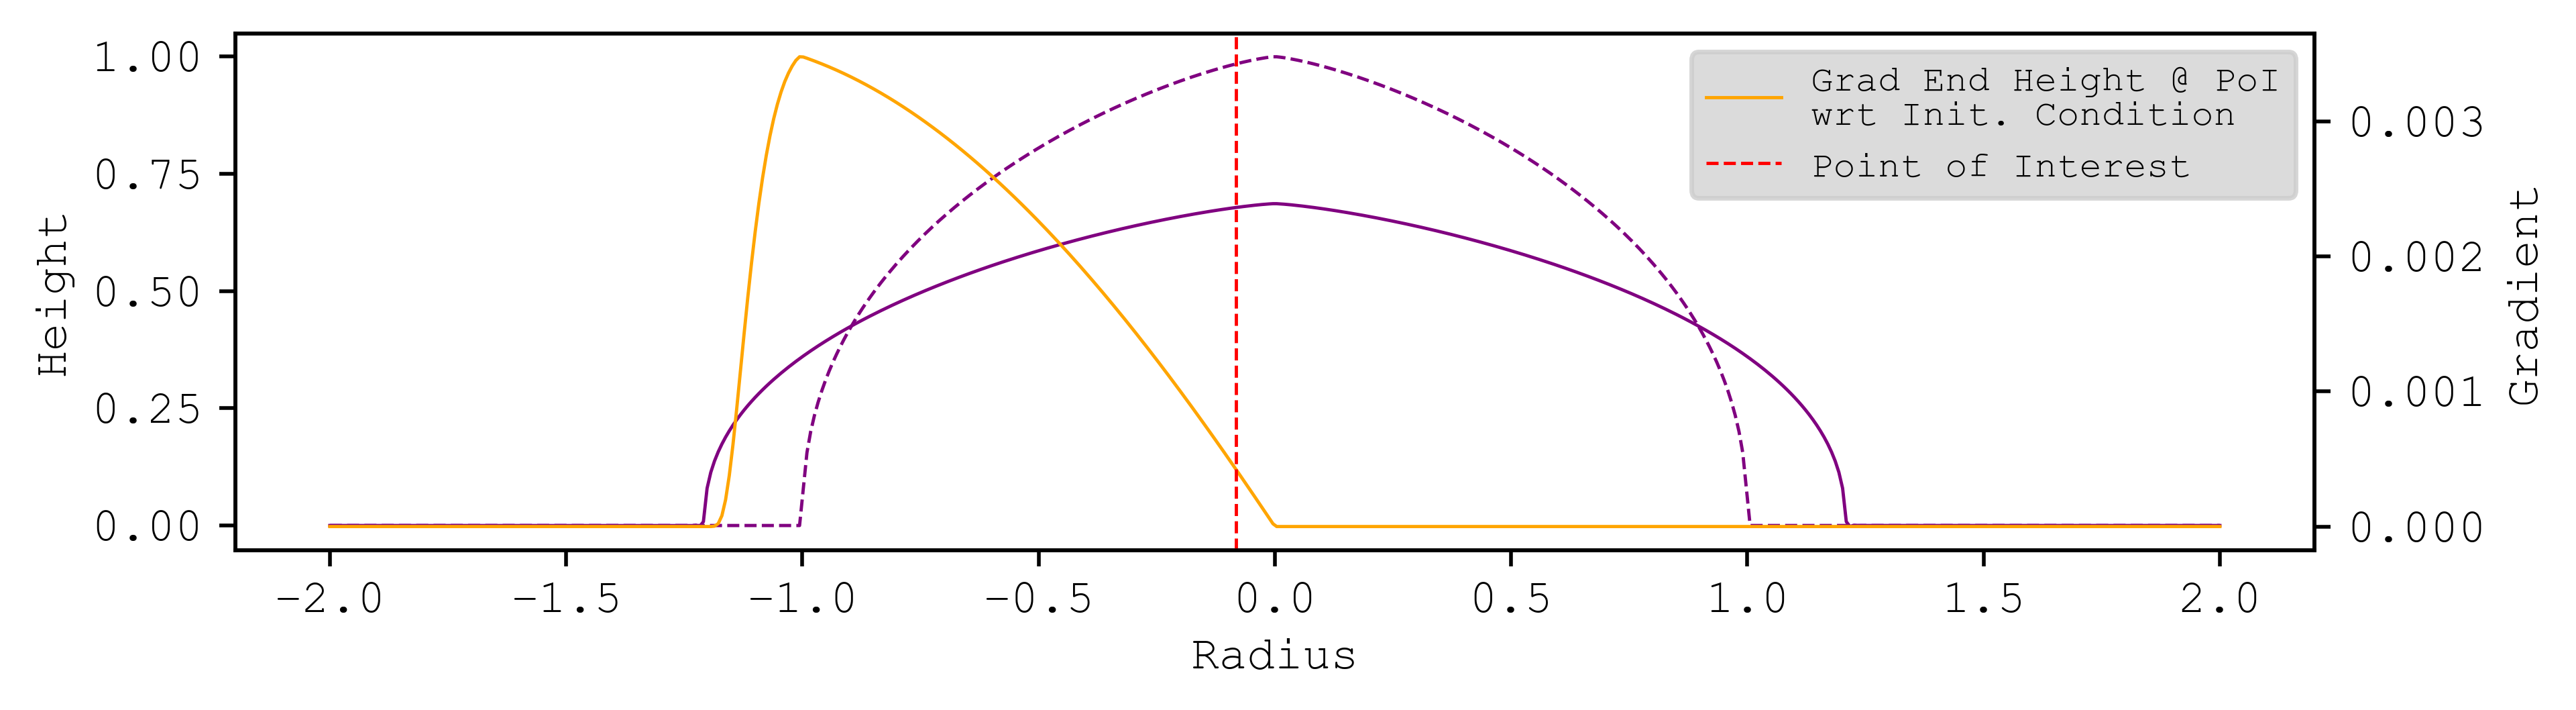

In [6]:
_, ax1 = plt.subplots(figsize=(8, 2), dpi=500)

ax1.plot(space_grid, u_init[0].detach(), color='purple', linestyle='--', linewidth=0.7)
ax1.plot(space_grid, sols[-1].detach(), color='purple', linewidth=0.7)
ax1.set_ylabel("Height")
ax1.set_xlabel("Radius")

ax2 = ax1.twinx()
ax2.plot(space_grid, u_init.grad[0].detach(), label='Grad End Height @ PoI\nwrt Init. Condition', linewidth=0.7, color='orange')
ax2.axvline(space_grid[poi_idx], color='red', linestyle='--', label='Point of Interest', linewidth=0.7)
ax2.set_ylabel("Gradient")
ax2.legend(facecolor='lightgray', fontsize=8)

### Modeling Glacier Depth Measurements
Glacier depth measurements taken on the left slope will inform downstream inference and prediction.

In [7]:
# Analytically simulate a glacier and noisily measure its depth at 10 separate times across 5 points on the left slope.
measurement_times = tnsr([t0 + tstep.item() * i for i in range(0,50,5)]).double() + tstep.item() * 5
# To simplify things, we'll take measurements on the mesh.
# TODO adapt the mesh to observations.
measurement_poi_idx = torch.linspace(130, 256, 5, dtype=torch.int64)
measurement_poi = space_grid[measurement_poi_idx]

# Generate the true depths.
depths = hi.halfar_ice_analytical(r=measurement_poi[None, :], t=measurement_times[:, None], h0=h0, r0=r0, gamma=gamma)

In [8]:
print(measurement_times.numpy().round())

[ 5000. 10000. 15000. 20000. 25000. 30000. 35000. 40000. 45000. 50000.]


##### Define a Measurement Noise Model in Pyro
A simple, independent Gaussian noise model to the depth measurements.

In [9]:
def measurement_noise(true_depths_, noise_scale=0.05):
    return pyro.sample("measurements", dist.Normal(true_depths_, noise_scale).to_event(2))
measurements = measurement_noise(depths)

/var/folders/cy/bjbt3n4j2fn22yc8tb1wwmxm0000gp/T/ipykernel_93307/4080919711.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(["Less", '', '', '', '', "More"])


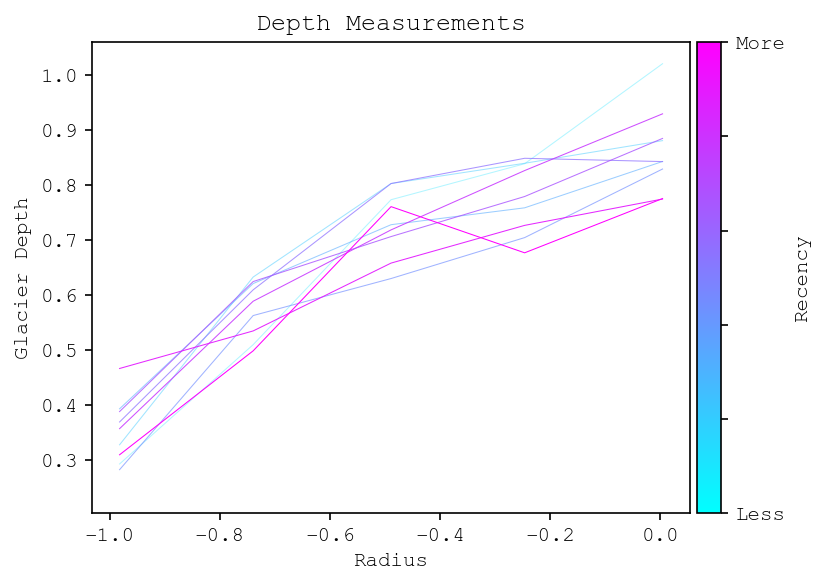

In [10]:
# Show measurements, mapping from cyan to pink as they become more recent.
_, ax = plt.subplots(dpi=150, figsize=(6, 4))
for i in range(measurements.shape[0]):
    recency = i / (measurements.shape[0] - 1)
    ax.plot(measurement_poi, measurements[i, :], color=plt.cm.cool(recency), linewidth=0.5, alpha=recency**0.5)
    # plt.cm.cool(1. - recency)
ax.set_ylabel("Glacier Depth")
ax.set_xlabel("Radius")
ax.set_title("Depth Measurements")
ax.set_aspect('equal')

# Add a colorbar showing the recency of the measurements.
sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.01)
cbar.ax.set_ylabel("Recency")
cbar.ax.set_yticklabels(["Less", '', '', '', '', "More"])

plt.tight_layout()
plt.show()

##### Full Observational Model
The cells below define simple, uniform prior over the unknown ice density and flow rate, and a depth model using an explicit euler method to solve for the glacier's height at the measurement times. The prior, depth mnodel, and noise model are then glued together.

In [11]:
DENSITY_RANGE = np.array((810, 940))
LOG_FLOW_RATE_RANGE = np.log(np.array((1e-20, 1e-15)))

# Define normal priors for the ice density and flow rate.
def prior():
    # return pyro.sample("ice_density", dist.Normal(DENSITY_RANGE.mean(), np.ptp(DENSITY_RANGE) / 3.)).double(), \
    #        pyro.sample("log_flow_rate", dist.Normal(LOG_FLOW_RATE_RANGE.mean(), np.ptp(LOG_FLOW_RATE_RANGE) / 3.)).double()
    return pyro.sample("ice_density", dist.Uniform(*DENSITY_RANGE)).double(), \
           pyro.sample("log_flow_rate", dist.Uniform(*LOG_FLOW_RATE_RANGE)).double()

In [12]:
# Define a model
# noinspection PyShadowingNames
def true_depth_model(t0, ts, u0, ice_density, log_flow_rate, max_tspan, use_analytic: bool):
    """

    :param t0: The absolute time of the initial condition. (scalar)
    :param ts: The absolute times at which to solve for the glacier's height. (vector)
    :param u0: The initial state of the mesh at t=0. (vector)
    :param ice_density: The density of the ice (rho). (scalar)
    :param log_flow_rate: The log of the flow rate (log(A)). (scalar)
    :param max_tspan: The maximum time span to solve for at once. (scalar)
    :param use_analytic: Whether to use the analytic solution. (bool)
    :return: The heights of the glacier, across the mesh of radii, at each time.
    """

    max_tspan = tnsr(max_tspan).double()

    true_depths = []

    # Initialize the iteratively updated solution.
    ul = u0

    tl = tnsr(t0).double()
    for t in ts:

        if use_analytic:
            ul = hi.halfar_ice_analytical(r=space_grid, t=t, h0=h0, r0=r0, gamma=hi.stable_gamma(rho=ice_density, lA=log_flow_rate), differentiable=True)
        else:
            try:
                while t - tl > max_tspan:
                    # Solve for the solution at the maximum time span.
                    ul = num_hi_model(*torch.atleast_2d(max_tspan, ul, ice_density, log_flow_rate))[0]
                    tl = tl + max_tspan
                else:
                    # TODO adapt both the mesh and the spatial domain (e.g. to exclude the numerically unstable glacier edges) to focus
                    #  on the regions of interest (where the observations occurred).
                    ul = num_hi_model(*torch.atleast_2d(t - tl, ul, ice_density, log_flow_rate))[0]
            except RuntimeError:
                print(f"Failed at t={t.item():.2f} with ice_density={ice_density.item():.2f} and flow_rate={log_flow_rate.exp().item()}")
                raise

        tl = t

        # Append the solution at this time to the list.
        true_depths.append(ul)

    return torch.stack(true_depths)

In [13]:
# noinspection PyShadowingNames
def model(use_analytic: bool, max_tspan=1000.):
    # Sample the ice density and flow rate from the prior.
    ice_density, log_flow_rate = prior()

    # Solve for the true depths at the measurement times.
    # Note: assume a fully known u_init for now.
    true_depths = true_depth_model(t0, measurement_times, u_init, ice_density, log_flow_rate,
                                   use_analytic=use_analytic, max_tspan=max_tspan)

    # Sample the measurements from the measurement noise model.
    return measurement_noise(true_depths[:, measurement_poi_idx])

### Inference
Here, we condition on the noisy depth measurements and infer a posterior distribution over the ice density and flow rate. We do this using both the analytic and numeric models, and compare their loss progressions and posterior distributions.

In [14]:
num_losses, ana_losses = [], []

num_guide, ana_guide = [pyro.infer.autoguide.AutoMultivariateNormal(
    prior,
    init_loc_fn=pyro.infer.autoguide.init_to_median,
    init_scale=0.1
) for _ in range(2)]

lr_schedule = [
    (2000, 1e-3),
    (2000, 5e-4),
    (2000, 1e-4),
    (2000, 5e-5),
    (2000, 1e-5),
]

from typing import List, Tuple

# noinspection PyShadowingNames
def infer(guide, lr_schedule: List[Tuple[int, float]], losses: List[float], use_analytic: bool):
    for steps, lr in lr_schedule:
        with pyro.condition(data={"measurements": measurements}):
            losses_, _ =  run_inference(
                model=lambda: model(use_analytic=use_analytic),
                prior=prior,
                guide=guide,
                steps=steps,
                verbose=True,
                verbose_every=10,
                max_retry_solve=100,
                lr=lr
            )
            losses.extend(losses_)

In [ ]:
infer(ana_guide, lr_schedule, ana_losses, use_analytic=True)
infer(num_guide, lr_schedule, num_losses, use_analytic=False)

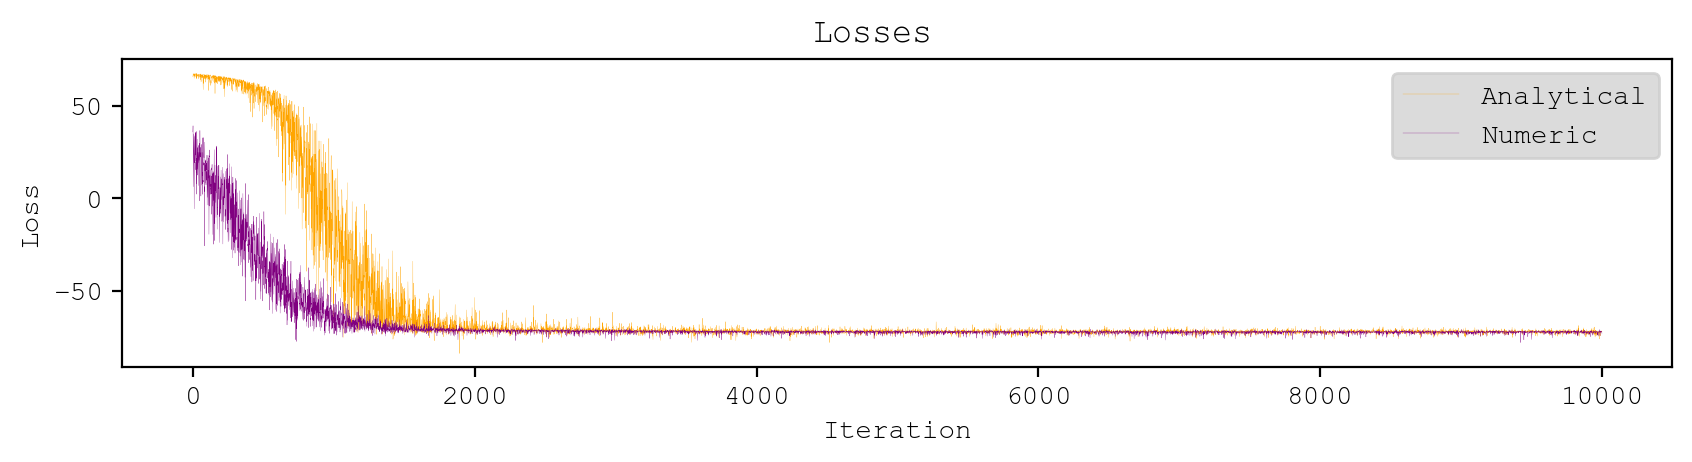

In [16]:
plt.figure(figsize=(10, 2), dpi=200)
plt.suptitle("Losses")
plt.plot(ana_losses, linewidth=0.1, color='orange', label="Analytical")
plt.plot(num_losses, linewidth=0.1, color='purple', label="Numeric")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(facecolor='lightgray')

In [17]:
def get_posterior_samples(guide, n: int):
    posterior_samples = []
    for i in range(n):
        psample = guide()
        posterior_samples.append((psample["ice_density"].item(), psample["log_flow_rate"].item()))
    return np.array(posterior_samples)

In [18]:
# Plot scatter of posterior samples. TODO plot posterior density contours from guide.
ana_posterior_samples = get_posterior_samples(ana_guide, 1000)
num_posterior_samples = get_posterior_samples(num_guide, 1000)

/var/folders/cy/bjbt3n4j2fn22yc8tb1wwmxm0000gp/T/ipykernel_93307/2519369849.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f"{np.exp(tick):.1e}" for tick in ax.get_xticks()])


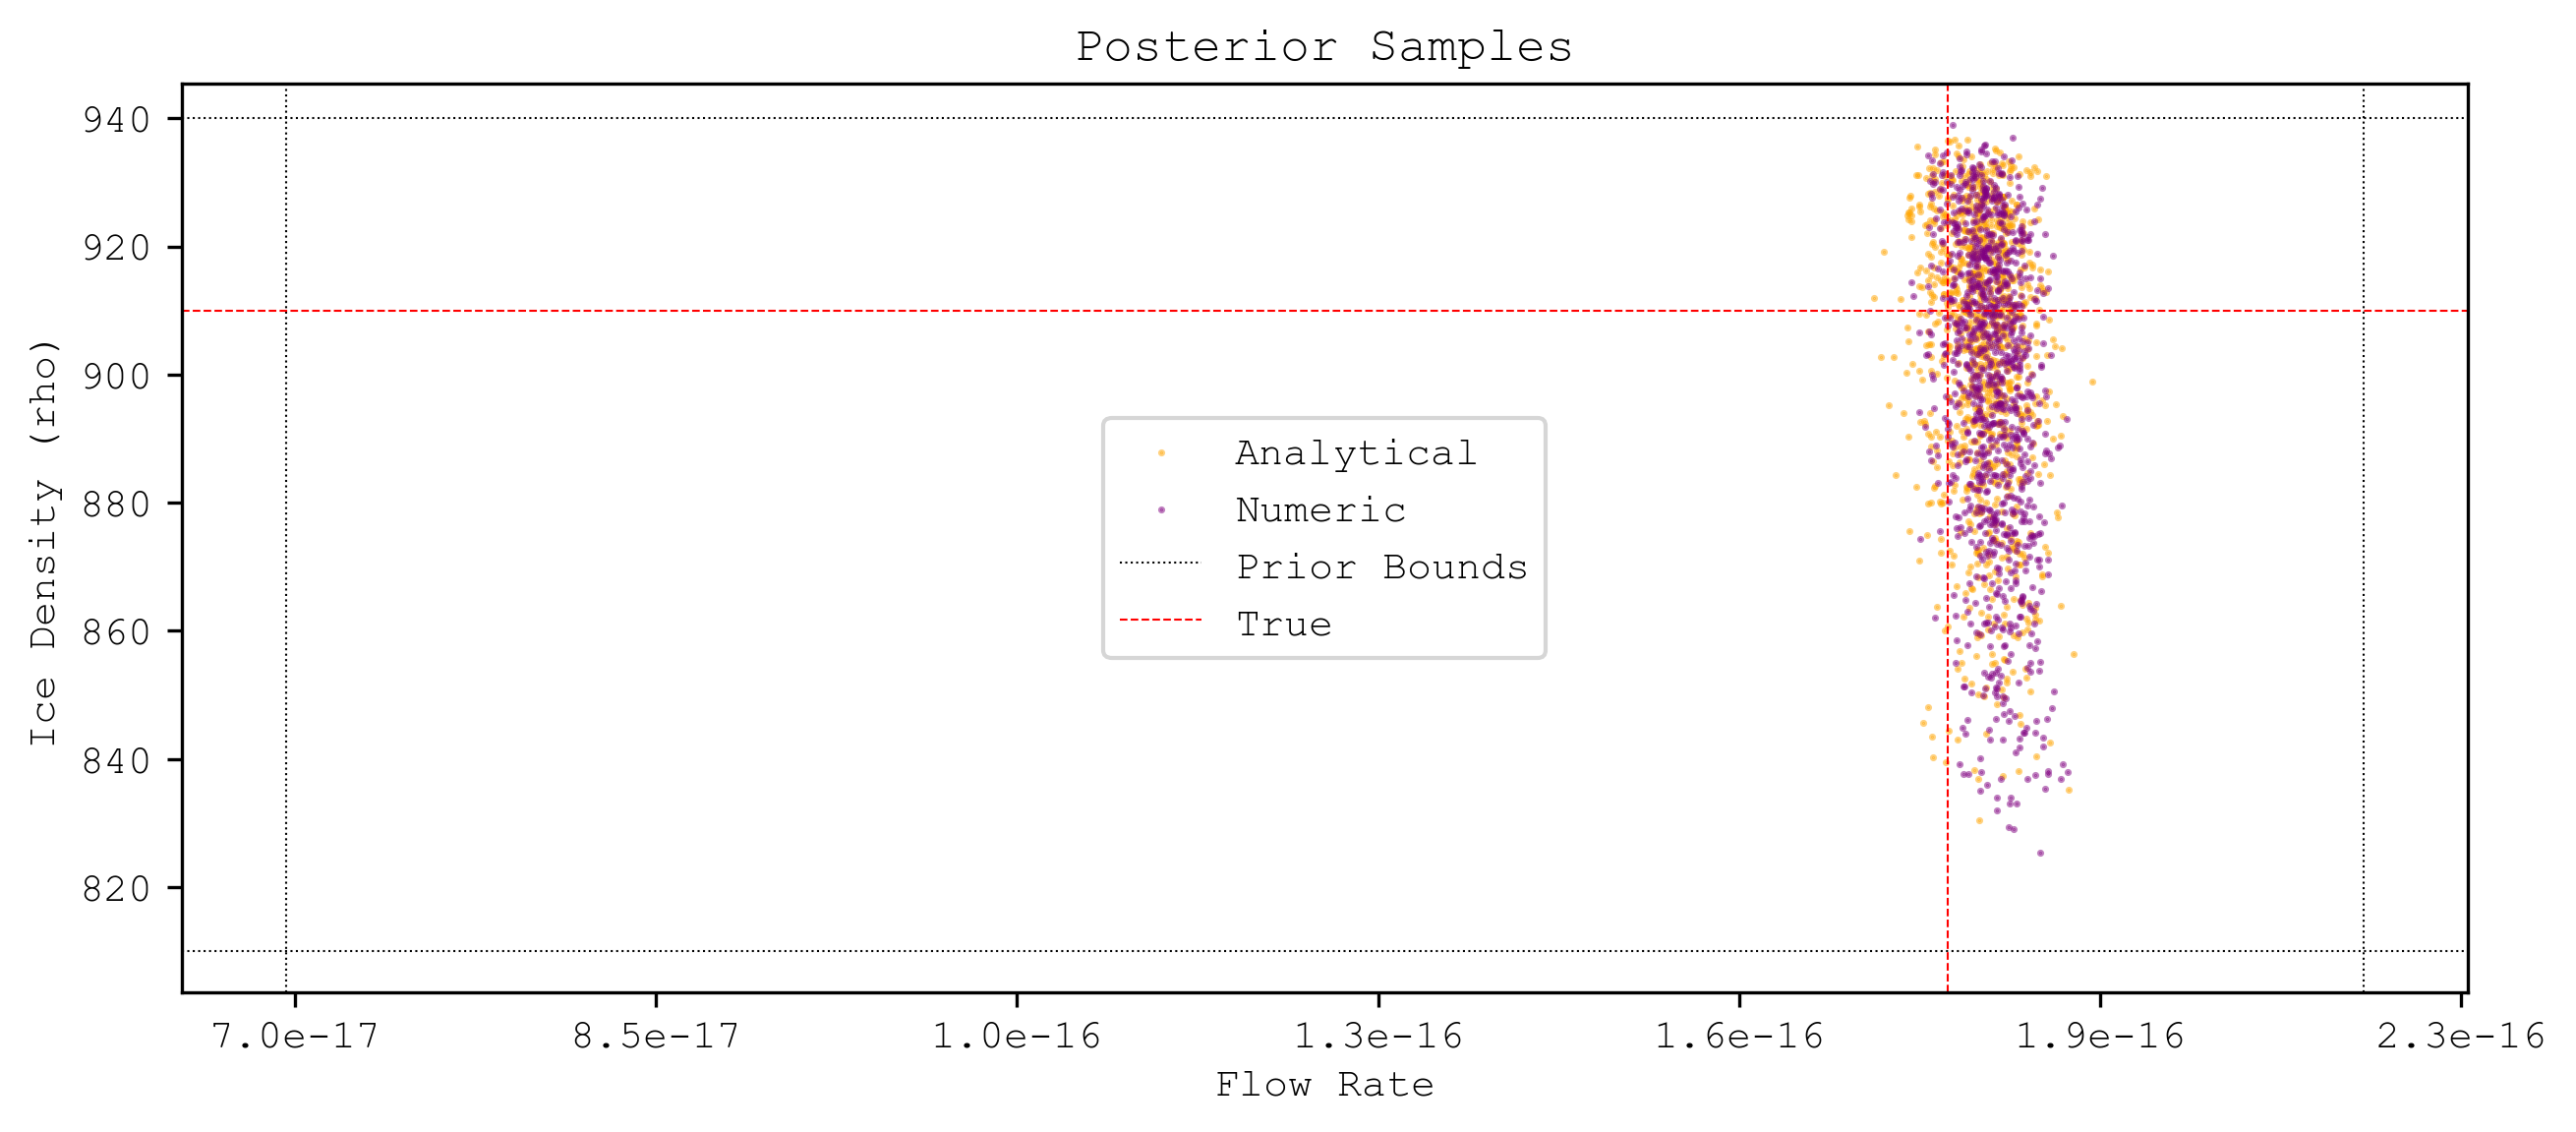

In [19]:
_, ax = plt.subplots(figsize=(10, 4), dpi=300)
ax.set_title("Posterior Samples")
ax.scatter(ana_posterior_samples[:, 1], ana_posterior_samples[:, 0], s=0.5, alpha=0.5, color='orange', label="Analytical")
ax.scatter(num_posterior_samples[:, 1], num_posterior_samples[:, 0], s=0.5, alpha=0.5, color='purple', label="Numeric")
ax.set_xticklabels([f"{np.exp(tick):.1e}" for tick in ax.get_xticks()])
ax.set_xlabel("Flow Rate")
ax.set_ylabel("Ice Density (rho)")

# Draw a box around the uniform prior region.
ax.axvline(LOG_FLOW_RATE_RANGE[0], color='black', linestyle=':', linewidth=0.5)
ax.axvline(LOG_FLOW_RATE_RANGE[1], color='black', linestyle=':', linewidth=0.5)
ax.axhline(DENSITY_RANGE[0], color='black', linestyle=':', linewidth=0.5)
ax.axhline(DENSITY_RANGE[1], color='black', linestyle=':', linewidth=0.5, label="Prior Bounds")

# Plot vline and hline at the true values. Use thin lines.
ax.axvline(true_log_flow_rate.item(), color='red', linestyle='--', linewidth=0.5, label="True")
ax.axhline(true_ice_density.item(), color='red', linestyle='--', linewidth=0.5)
ax.legend()
plt.show()

### Multifidelity inference

In [2]:
def stable_gamma(rho, lA, gravity=9.81, n=3.):
    ncoef = (2. / (n + 2.))
    lpg = torch.log(torch.as_tensor(rho * gravity))
    lApgn = lA + n * lpg
    return ncoef * torch.exp(lApgn)


def t0f(r0, h0, gamma=1.):
    return (1. / (18. * gamma)) * ((7. / 4.) ** 3.) * (r0 ** 4. / h0 ** 7.)


def halfar_ice_analytical(r, t, h0, r0, gamma=1.):
    gamma = torch.as_tensor(gamma)[..., None, None]
    t0 = t0f(r0, h0, gamma)

    # We assume the user's t0 == 0, but the analytical solution calculates a t0 depending on the parameters.
    # So add that value to the user's t to get the correct time.
    t = t + t0
    r = r.abs()

    hterm = (h0 * (t0 / t) ** (1. / 9.))

    y1 = (t0 / t) ** (1. / 18.) * (r / r0)

    y2 = (1. - y1 ** (4. / 3.))
    y2 = y2.clamp(min=0.)

    rterm = y2 ** (3. / 7.)

    return hterm * rterm

In [3]:
class NoisyHalfarModel(pyro.nn.PyroModule):
    space_grid: torch.Tensor
    u_init: torch.Tensor
    measurement_spatial_scale: float

    noise_scale: torch.Tensor
    h0: torch.Tensor
    r0: torch.Tensor
    min_ice_density: torch.Tensor
    min_log_flow_rate: torch.Tensor
    max_ice_density: torch.Tensor
    max_log_flow_rate: torch.Tensor

    def __init__(
        self,
        space_grid: torch.Tensor,
        u_init: torch.Tensor,
        *,
        measurement_spatial_scale: float = 1.,
        noise_scale: float = 0.05,
        h0: float = 1.,
        r0: float = 1.,
        ice_density_range: typing.Tuple[float, float] = (810., 940.),
        log_flow_rate_range: typing.Tuple[float, float] = (math.log(1e-20), math.log(1e-15)),
    ):
        super().__init__()
        self.u_init = u_init
        self.measurement_spatial_scale = measurement_spatial_scale

        self.register_buffer("space_grid", space_grid)
        self.register_buffer("noise_scale", torch.as_tensor(noise_scale))

        self.register_buffer("h0", torch.as_tensor(h0))
        self.register_buffer("r0", torch.as_tensor(r0))

        self.register_buffer("min_ice_density", torch.as_tensor(ice_density_range[0]))
        self.register_buffer("min_log_flow_rate", torch.as_tensor(log_flow_rate_range[0]))

        self.register_buffer("max_ice_density", torch.as_tensor(ice_density_range[1]))
        self.register_buffer("max_log_flow_rate", torch.as_tensor(log_flow_rate_range[1]))

    @pyro.nn.PyroSample
    def ice_density(self):
        return dist.Uniform(self.min_ice_density, self.max_ice_density)

    @pyro.nn.PyroSample
    def log_flow_rate(self):
        return dist.Uniform(self.min_log_flow_rate, self.max_log_flow_rate)

    def forward(
        self,
        measurement_times: torch.Tensor,
        measured_depths: typing.Optional[torch.Tensor] = None,
    ) -> torch.Tensor:

        depths = [self.u_init]
        for t in measurement_times:
            depths.append(
                halfar_ice_analytical(
                    r=self.space_grid,
                    t=t,
                    h0=self.h0,
                    r0=self.r0,
                    gamma=stable_gamma(rho=self.ice_density, lA=self.log_flow_rate),
                )
            )

        depths = pyro.deterministic("depths", torch.cat(depths[1:], dim=-2), event_dim=2)  # TODO dim?

        interpolated_depths = torch.nn.functional.interpolate(
            depths[None, ...] if len(depths.shape) == 2 else depths,
            scale_factor=self.measurement_spatial_scale,
            mode='nearest',
            recompute_scale_factor=True,
        )
        interpolated_depths = pyro.deterministic("interpolated_depths", interpolated_depths, event_dim=2)
        return pyro.sample("measurements", dist.Normal(interpolated_depths[..., :, measurement_poi_idx], self.noise_scale).to_event(2), obs=measured_depths)

In [4]:
# Declare some ground truth parameters affecting flow and deformation rates.
true_ice_density = torch.tensor(910.).double()
true_log_flow_rate = torch.log(torch.tensor(1e-16)).double()

# The initial height and radius of the glacier in the standard dome shape.
h0, r0 = torch.as_tensor(1.).double(), torch.as_tensor(1.).double()

# The gamma term is a constant affecting overall flow rates.
gamma = stable_gamma(rho=true_ice_density, lA=true_log_flow_rate)

# Domain will be from -2. to 2. HalfarIceNonLinearPolar uses a lagrangian FE space of degree 1, meaning
#  our solutions will have n_elements + 1 points. x here is the radius of a radially symmetric dome of ice.
high_fidelity_n_elements, low_fidelity_n_elements = 512, 128
high_fidelity_space_grid = torch.linspace(-2., 2., high_fidelity_n_elements).double()
low_fidelity_space_grid = torch.linspace(-2., 2., low_fidelity_n_elements).double()

# Analytically simulate a glacier and noisily measure its depth at 10 separate times across 5 points on the left slope.
measurement_t0 = 0.0
measurement_tstep = torch.tensor(1000).double()[None, None]
measurement_times = torch.tensor([measurement_t0 + measurement_tstep.item() * i for i in range(0,50,5)]).double() + measurement_tstep.item() * 5

# To simplify things, we'll take measurements on the mesh.
# TODO adapt the mesh to observations.
measurement_poi_idx = torch.linspace(130, 256, 5, dtype=torch.int64)
measurement_poi = high_fidelity_space_grid[measurement_poi_idx]

# Generate the true depths.
depths = halfar_ice_analytical(r=measurement_poi[None, :], t=measurement_times[:, None], h0=h0, r0=r0, gamma=gamma)
measurements = depths + torch.randn_like(depths) * 0.05

In [5]:
low_fidelity_measurement_spatial_scale = float(high_fidelity_space_grid.shape[0]) / float(low_fidelity_space_grid.shape[0])

high_fidelity_model = NoisyHalfarModel(
    space_grid=high_fidelity_space_grid,
    u_init=halfar_ice_analytical(r=high_fidelity_space_grid, t=measurement_times[0:1], h0=h0, r0=r0, gamma=gamma)[None, :],
)

low_fidelity_model = NoisyHalfarModel(
    space_grid=low_fidelity_space_grid,
    u_init=halfar_ice_analytical(r=low_fidelity_space_grid, t=measurement_times[0:1], h0=h0, r0=r0, gamma=gamma)[None, :],
    measurement_spatial_scale=low_fidelity_measurement_spatial_scale,
)

In [7]:
reparam = pyro.infer.reparam.strategies.AutoReparam(centered=0.0)
surrogate_ = reparam(low_fidelity_model)

surrogate_guide = pyro.infer.autoguide.AutoMultivariateNormal(surrogate_)
surrogate_guide(measurement_times, measurements)  # initialize parameters

surrogate_elbo = pyro.infer.RenyiELBO(alpha=0., num_particles=10, vectorize_particles=True)
# surrogate_elbo = pyro.infer.Trace_ELBO()(surrogate_, surrogate_guide)

# fit surrogate guide
optim = torch.optim.Adam(surrogate_guide.parameters(), lr=1e-3)
for step in range(2000):
    loss = surrogate_elbo.loss_and_grads(surrogate_, surrogate_guide, measurement_times, measurements)
    # loss = surrogate_elbo(measurement_times, u_init, measurements)
    # loss.backward()
    optim.step()
    optim.zero_grad()
    if step % 100 == 0:
        print(f"step: {step}, loss: {loss}")


step: 0, loss: 72.5856279816618
step: 100, loss: 70.2110886442796
step: 200, loss: 66.0825600614039
step: 300, loss: 52.63718964640358
step: 400, loss: 16.179921537215332
step: 500, loss: 5.459754437571733
step: 600, loss: -28.667491884582525
step: 700, loss: -52.42158802612419
step: 800, loss: -69.56749199932703
step: 900, loss: -75.13289294998009
step: 1000, loss: -76.67306885250629
step: 1100, loss: -76.35129584093889
step: 1200, loss: -67.64899518904583
step: 1300, loss: -76.56062636367858
step: 1400, loss: -76.95446973113488
step: 1500, loss: -76.4571567111145
step: 1600, loss: -75.4728255380388
step: 1700, loss: -76.27303881451328
step: 1800, loss: -76.98479522283465
step: 1900, loss: -77.81000829799834


In [53]:
all_multifidelity_posterior_samples = []

for num_samples in [1e1, 1e2, 1e3, 1e4]:
    # importance
    log_weights, high_fidelity_model_trace, _ = pyro.infer.importance.vectorized_importance_weights(
        reparam(high_fidelity_model),
        surrogate_guide,
        measurement_times,
        measurements,
        num_samples=num_samples,
        max_plate_nesting=0,
    )
    log_normalizer = torch.logsumexp(log_weights - math.log(log_weights.shape[0]), dim=0)

    multifidelity_log_normalized_weights = log_weights - log_normalizer
    weighted_multifidelity_posterior_samples = {
        k: high_fidelity_model_trace.nodes[k]["value"]
        for k in {"ice_density", "log_flow_rate"}  # , "interpolated_depths"}
    }

    # plot the importance sampling posterior
    with torch.no_grad():
        resampling_indices = dist.Categorical(logits=multifidelity_log_normalized_weights).sample((10000,))
        resampled_multifidelity_posterior_samples = {
            k: v[resampling_indices]
            for k, v in weighted_multifidelity_posterior_samples.items()
        }

    all_multifidelity_posterior_samples.append((num_samples, multifidelity_log_normalized_weights, resampled_multifidelity_posterior_samples))

In [29]:
log_weights.shape

torch.Size([1000])

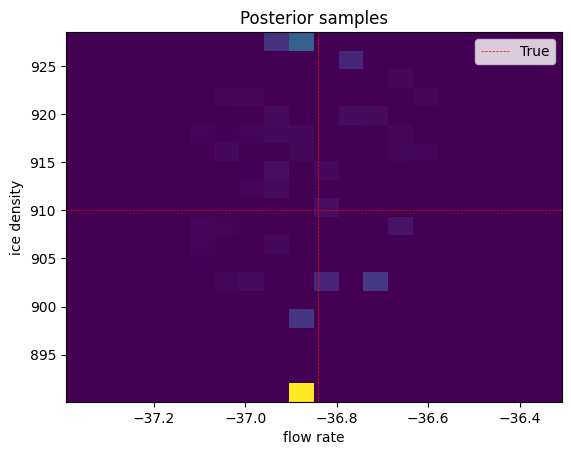

In [30]:
plt.hist2d(resampled_multifidelity_posterior_samples["log_flow_rate"].numpy(), resampled_multifidelity_posterior_samples["ice_density"].numpy(), bins=20)
# plt.scatter(log_flow_rate_samples.numpy(), ice_density_samples.numpy())
plt.axvline(true_log_flow_rate.item(), color='red', linestyle='--', linewidth=0.5, label="True")
plt.axhline(true_ice_density.item(), color='red', linestyle='--', linewidth=0.5)
plt.title("Posterior samples")
plt.xlabel("flow rate")
plt.ylabel("ice density")
plt.legend()

### Prediction
Now we push our inference forward into a prediction of the glaciers position in the future. Both the analytic and numeric approaches are used to generate prior and posterior predictive states for each posterior generated by inference using analytic and numeric solvers respectively.

In [60]:
def get_pointwise_between(preds):
    ret = preds.mean(dim=0).squeeze(), preds.quantile(0.95, dim=0).squeeze(), preds.quantile(0.05, dim=0).squeeze()

    if isinstance(preds, torch.Tensor):
        return tuple(x.detach().numpy() for x in ret)
    return ret

def plot_preds(prior_preds, low_fidelity_preds, list_posteriors, space_grid, pred_time, h0, r0, gamma):

    # Get the pointwise mean, upper and lower quartiles for each predictive distribution.
    prior_mean, prior_upper, prior_lower = get_pointwise_between(prior_preds)

    # Plot the prior and posterior predictive distributions.
    fig, ax = plt.subplots(dpi=500, figsize=(8, 2.8))

    ax.plot(space_grid, halfar_ice_analytical(r=space_grid, t=pred_time, h0=h0, r0=r0, gamma=gamma).squeeze(),
            color='black', linestyle='-.', linewidth=0.5, label="True")

    # ax.plot(space_grid, prior_mean, color='blue', linewidth=0.7, label="Prior Predictive", alpha=0.5)
    # ax.fill_between(space_grid, prior_lower, prior_upper, color='blue', alpha=0.02)

    posterior_mean, posterior_upper, posterior_lower = get_pointwise_between(low_fidelity_preds)
    ax.plot(space_grid, posterior_mean, color='blue', linewidth=0.7, label="Low Fidelity Posterior Predictive", alpha=0.5)
    ax.fill_between(space_grid, posterior_lower, posterior_upper, color='red', alpha=0.02)

    for (num_samples, log_weights, posterior_samples) in list_posteriors:
        posterior_preds = pyro.infer.Predictive(high_fidelity_model, posterior_samples=posterior_samples, return_sites=["log_flow_rate", "ice_density", "interpolated_depths"])(pred_time)
        posterior_mean, posterior_upper, posterior_lower = get_pointwise_between(posterior_preds["interpolated_depths"])
        ax.plot(space_grid, posterior_mean, linewidth=0.7, label=f"Posterior Predictive (n={num_samples})")
        ax.fill_between(space_grid, posterior_lower, posterior_upper, alpha=0.1)

    ax.set_ylabel("Height")
    ax.set_xlabel("Radius")
    ax.set_aspect('equal')
    plt.tight_layout()
    plt.legend(facecolor='lightgray', fontsize=7)

[ 5000. 10000. 15000. 20000. 25000. 30000. 35000. 40000. 45000. 50000.] --> tensor([100000.], dtype=torch.float64)


Text(0.5, 0.98, 'Multifidelity Posterior Predictive Inference')

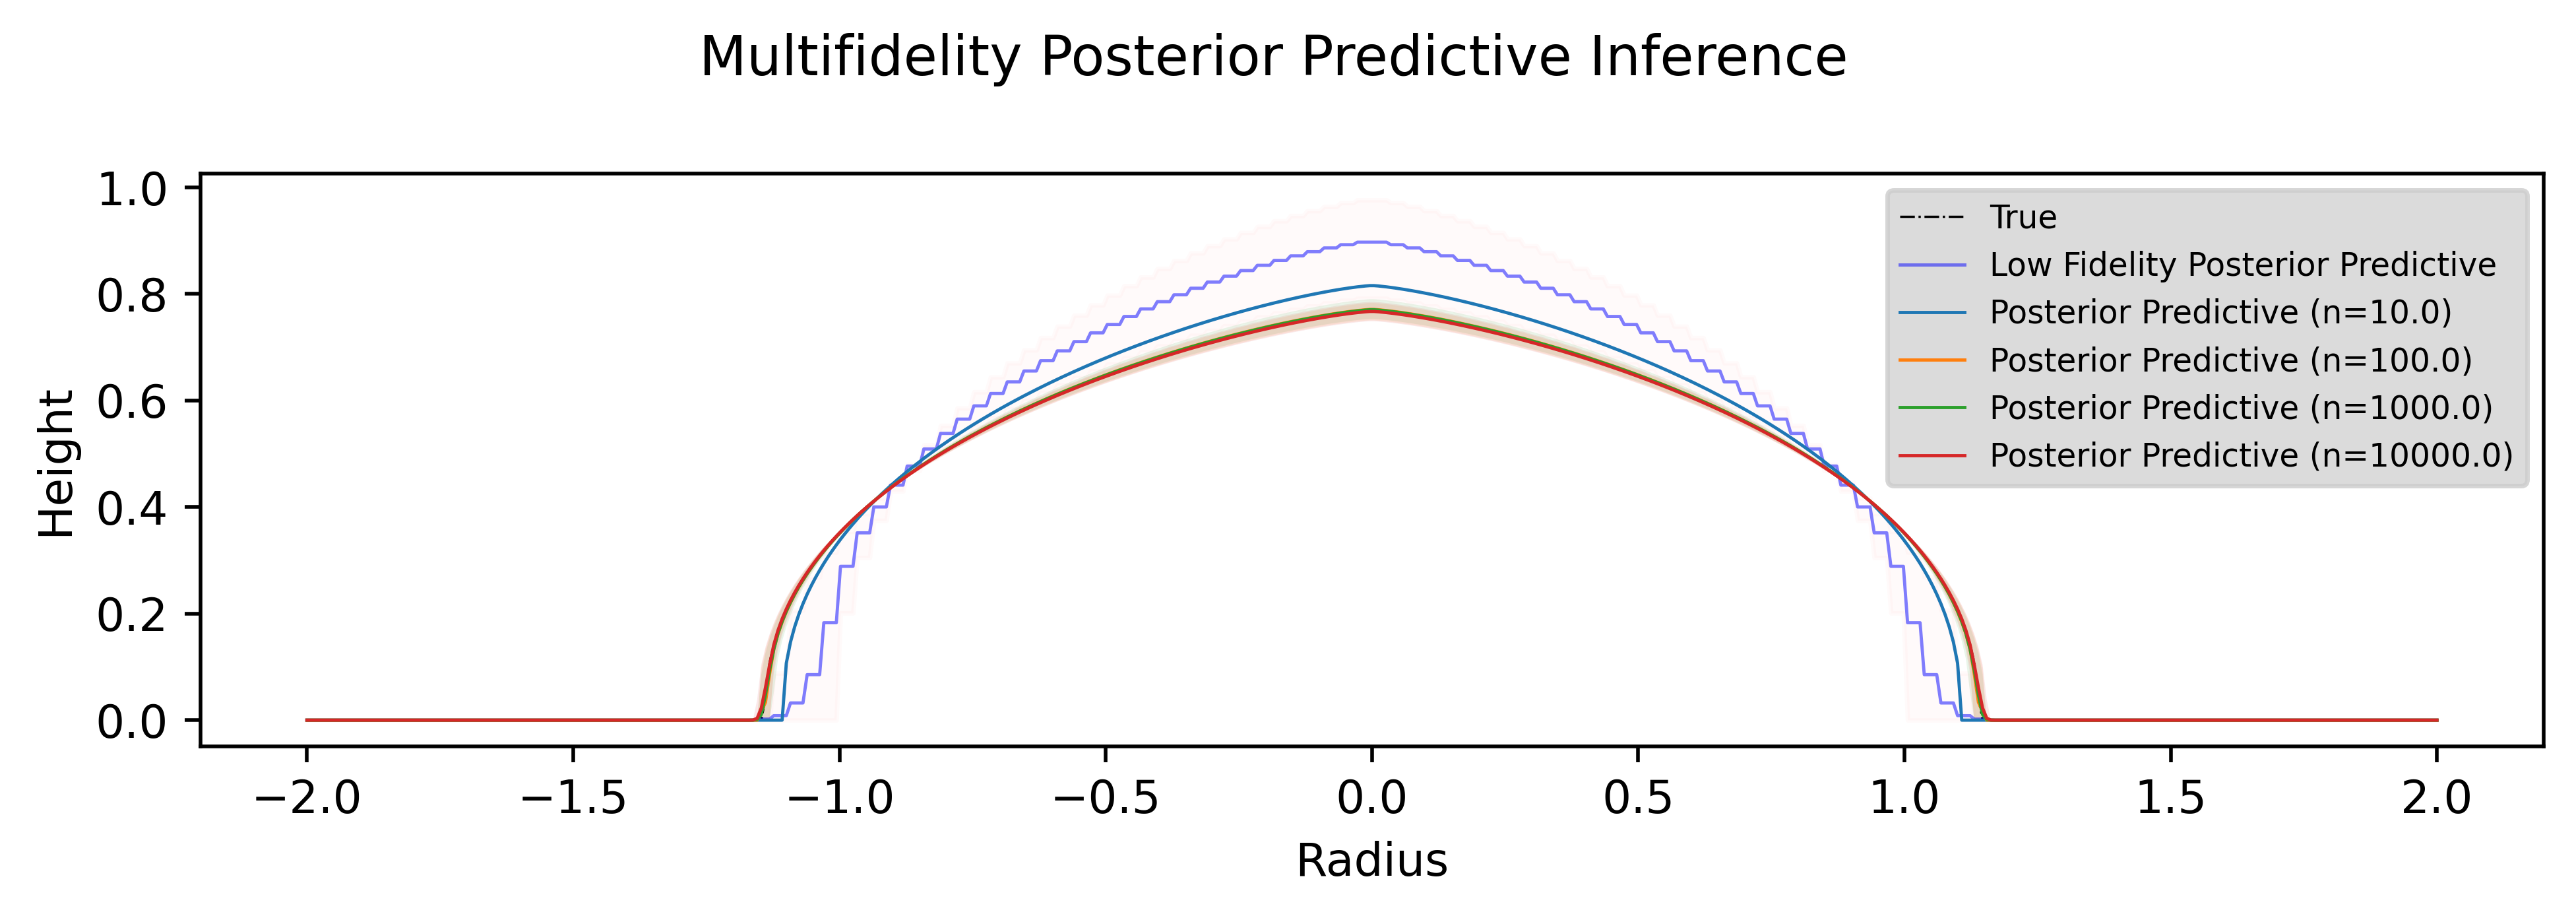

In [62]:
# The future time at which to predict the glacier's form.
t0 = 0.
pred_time = (measurement_times[-1:] - t0) * 2 + t0
print(measurement_times.numpy(), '-->', pred_time)

prior_predictive_samples = pyro.infer.Predictive(high_fidelity_model, num_samples=1000, return_sites=["log_flow_rate", "ice_density", "interpolated_depths"])(pred_time)
low_fidelity_posterior_predictive_samples = pyro.infer.Predictive(low_fidelity_model, guide=surrogate_guide, num_samples=1000, return_sites=["log_flow_rate", "ice_density", "interpolated_depths"])(pred_time)

plot_preds(prior_predictive_samples["interpolated_depths"], low_fidelity_posterior_predictive_samples["interpolated_depths"], all_multifidelity_posterior_samples, space_grid=high_fidelity_model.space_grid, pred_time=pred_time, h0=high_fidelity_model.h0, r0=high_fidelity_model.r0, gamma=gamma)
plt.suptitle("Multifidelity Posterior Predictive Inference")

##### Analytical

In [22]:
# We want to compare the prior and posterior predictive distributions, so generate prior samples first.
prior_samples = torch.tensor([prior() for _ in range(5000)])
ana_posterior_samples = torch.tensor(ana_posterior_samples)
num_posterior_samples = torch.tensor(num_posterior_samples)

In [23]:
# Prior and posterior predictive samples of glacier profiles at pred time, first, with the analytical solution.
prior_preds = hi.halfar_ice_analytical(r=space_grid[None, :], t=pred_time, h0=h0, r0=r0,
    gamma=hi.stable_gamma(rho=prior_samples[:, 0], lA=prior_samples[:, 1])[:, None])

ana_posterior_preds = hi.halfar_ice_analytical(r=space_grid[None, :], t=pred_time, h0=h0, r0=r0,
    gamma=hi.stable_gamma(rho=ana_posterior_samples[:, 0], lA=ana_posterior_samples[:, 1])[:, None])
num_posterior_preds = hi.halfar_ice_analytical(r=space_grid[None, :], t=pred_time, h0=h0, r0=r0,
    gamma=hi.stable_gamma(rho=num_posterior_samples[:, 0], lA=num_posterior_samples[:, 1])[:, None])

Text(0.5, 0.98, 'Analytical Predictives of Inference w/ Numeric Solver')

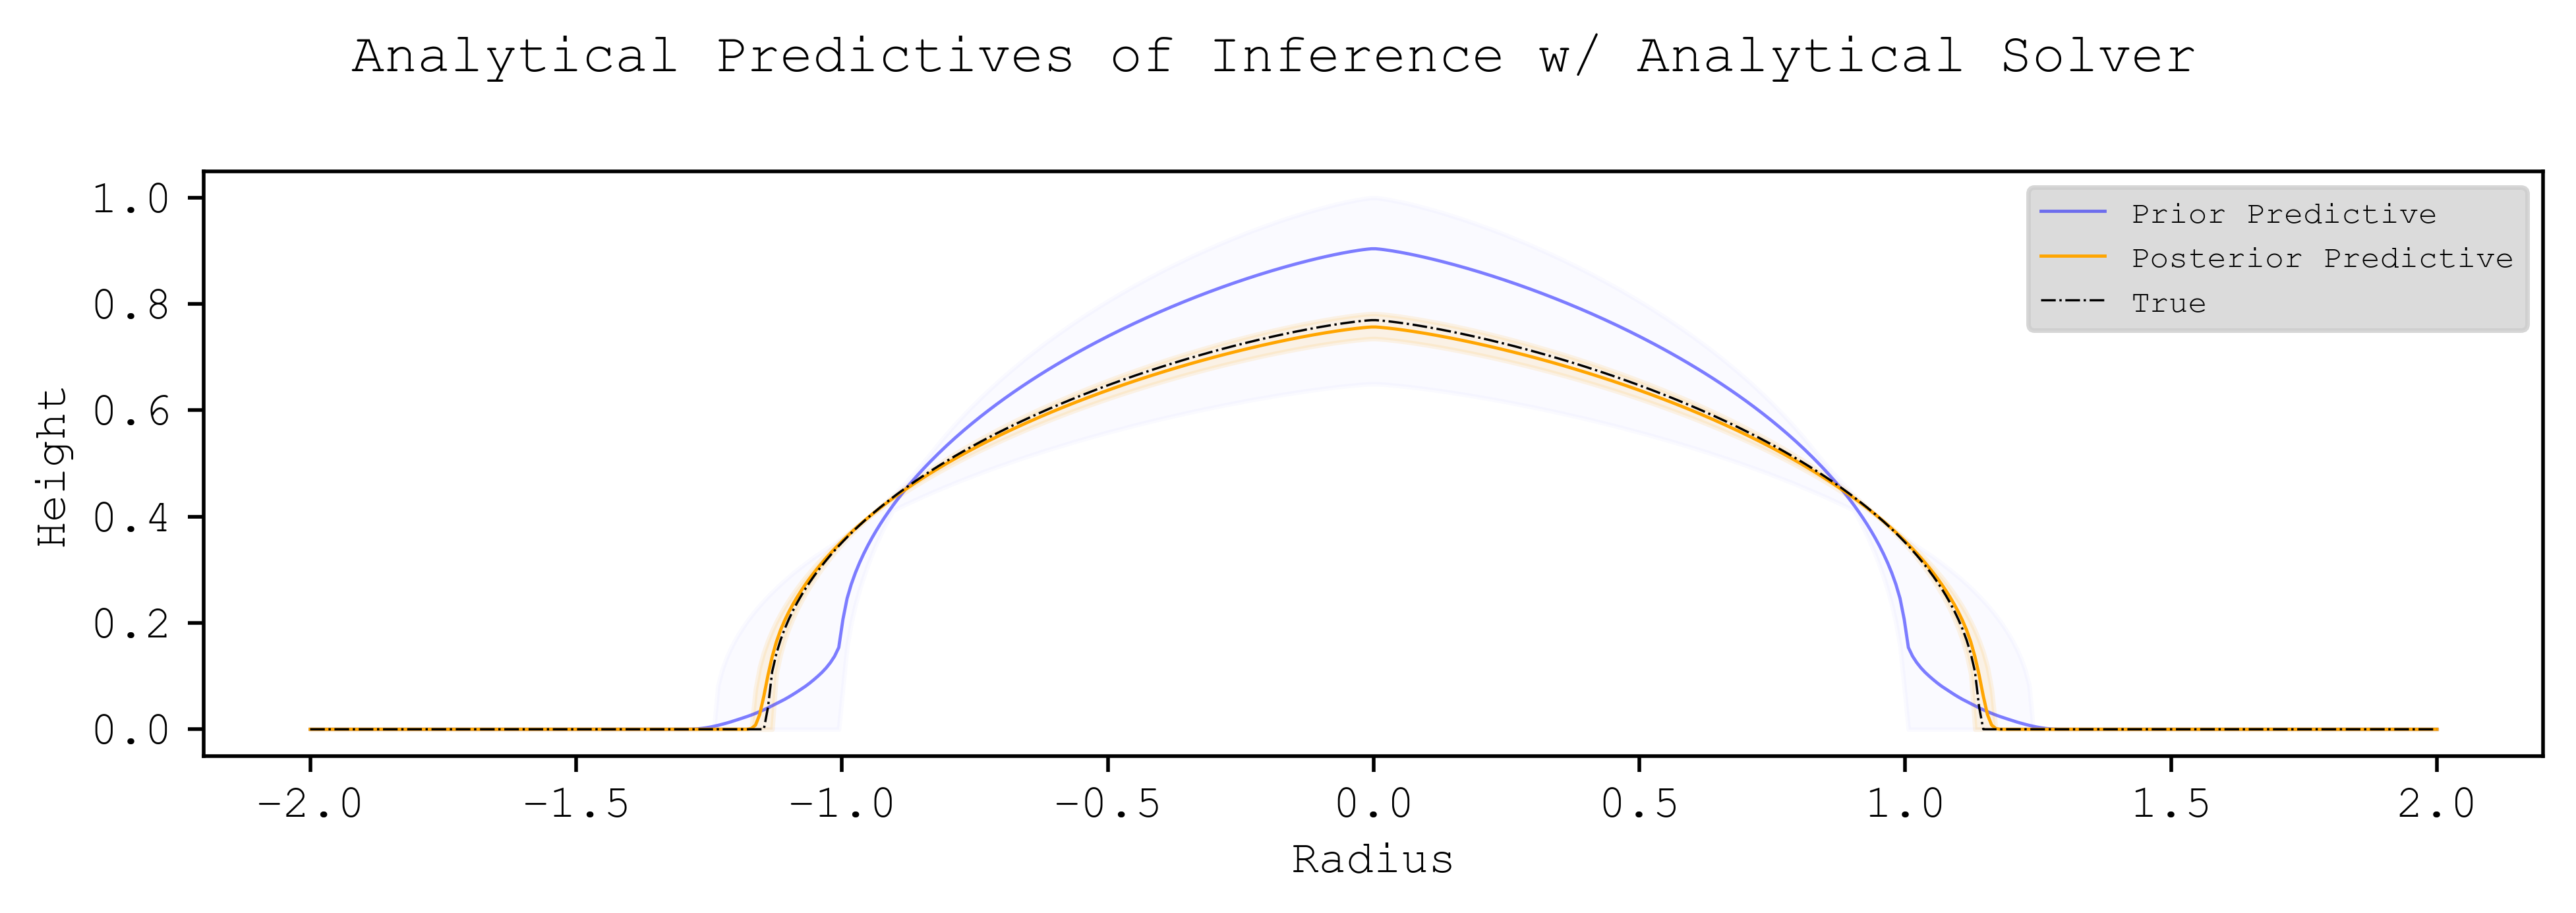

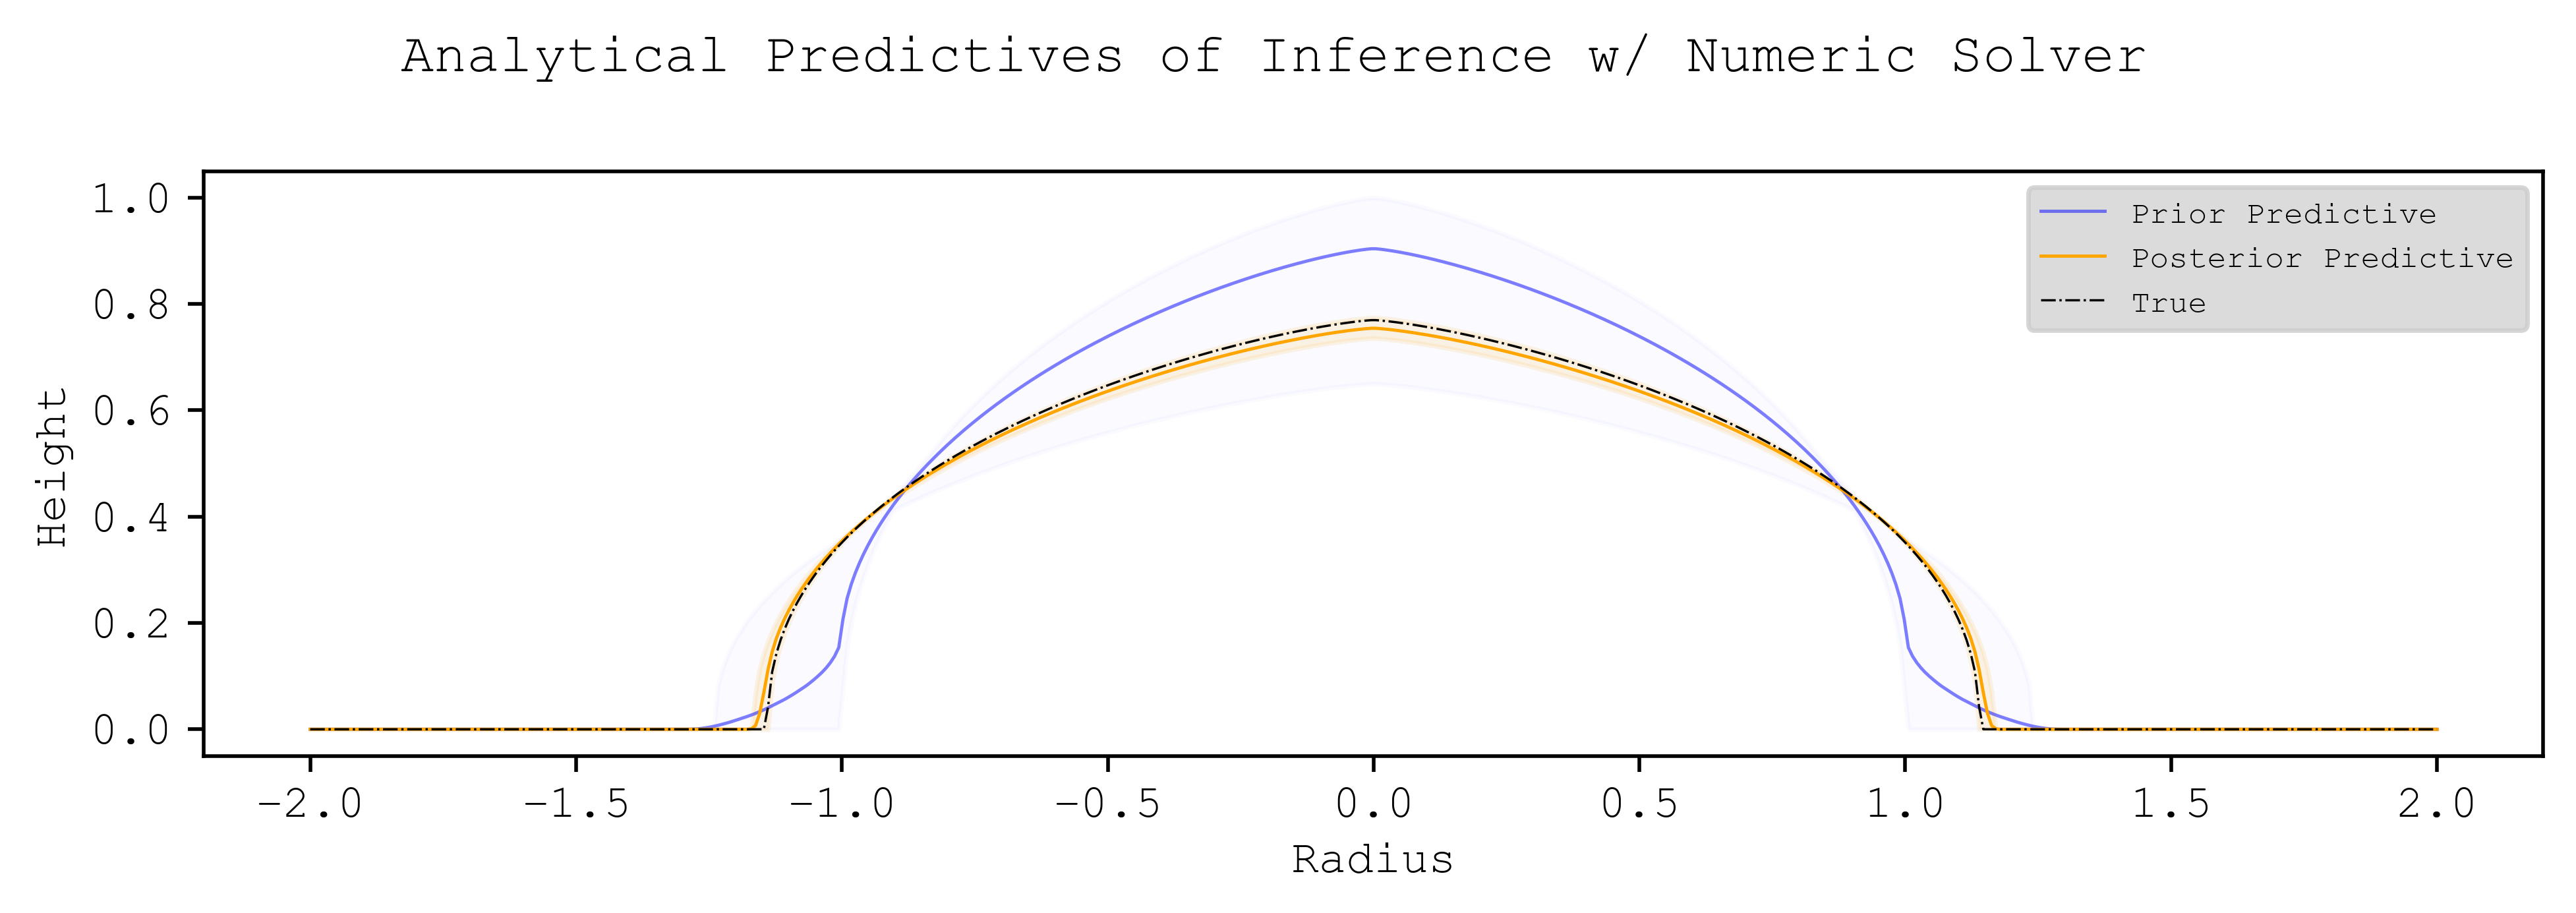

In [25]:
plot_preds(prior_preds, ana_posterior_preds)
plt.suptitle("Analytical Predictives of Inference w/ Analytical Solver")

plot_preds(prior_preds, num_posterior_preds)
plt.suptitle("Analytical Predictives of Inference w/ Numeric Solver")


##### Numeric

In [26]:
from src.utils import specify_if_solver_did_not_converge, SolverDidNotConvergeOnce

# Prior and posterior predictive glacier distributions, now with the numeric solver.

num_true_depth_model_wrapped = specify_if_solver_did_not_converge(true_depth_model)

# noinspection PyShadowingNames
def get_converged_sols(pred_time, u_init, samples):
    remaining_samples = len(samples) + 1
    sols = []
    converged_samples = []
    unconverged_samples = []
    for ice_density, log_flow_rate in samples:

        remaining_samples -= 1
        print(f"\r{remaining_samples:05d} samples remaining; {len(sols):05d} samples converged", end='')

        try:
            true_depths = num_true_depth_model_wrapped(
                t0=t0,
                ts=[pred_time],
                u0=u_init,
                ice_density=ice_density,
                log_flow_rate=log_flow_rate,
                max_tspan=1000.,
                use_analytic=False
            )[0]
            sols.append(true_depths)

            converged_samples.append((ice_density.item(), log_flow_rate.item()))
        except SolverDidNotConvergeOnce:
            unconverged_samples.append((ice_density.item(), log_flow_rate.item()))
            continue
    print()

    return torch.stack(sols), np.array(converged_samples), np.array(unconverged_samples)

In [27]:
pred_time = tnsr(pred_time).double()

print("Solving for prior predictive samples.")
prior_preds, prior_converged, prior_unconverged = get_converged_sols(pred_time, u_init, prior_samples[:10])
print(f"Prior Predictive: {prior_preds.shape[0]} converged samples")

print("Solving for analytic posterior predictive samples.")
ana_posterior_preds, ana_converged, ana_unconverged = get_converged_sols(pred_time, u_init, ana_posterior_samples[:10])
print(f"Posterior Predictive: {ana_posterior_preds.shape[0]} converged samples")

print("Solving for numeric posterior predictive samples.")
num_posterior_preds, num_converged, num_unconverged = get_converged_sols(pred_time, u_init, num_posterior_samples[:10])
print(f"Posterior Predictive: {num_posterior_preds.shape[0]} converged samples")

Solving for prior predictive samples.
00001 samples remaining; 00009 samples convergedFailed at t=100000.00 with ice_density=909.55 and flow_rate=7.224882143148665e-16

Prior Predictive: 9 converged samples
Solving for analytic posterior predictive samples.
00001 samples remaining; 00009 samples converged
Posterior Predictive: 10 converged samples
Solving for numeric posterior predictive samples.
00001 samples remaining; 00009 samples converged
Posterior Predictive: 10 converged samples


Text(0.5, 0.98, 'Numeric Predictives of Inference w/ Numeric Solver')

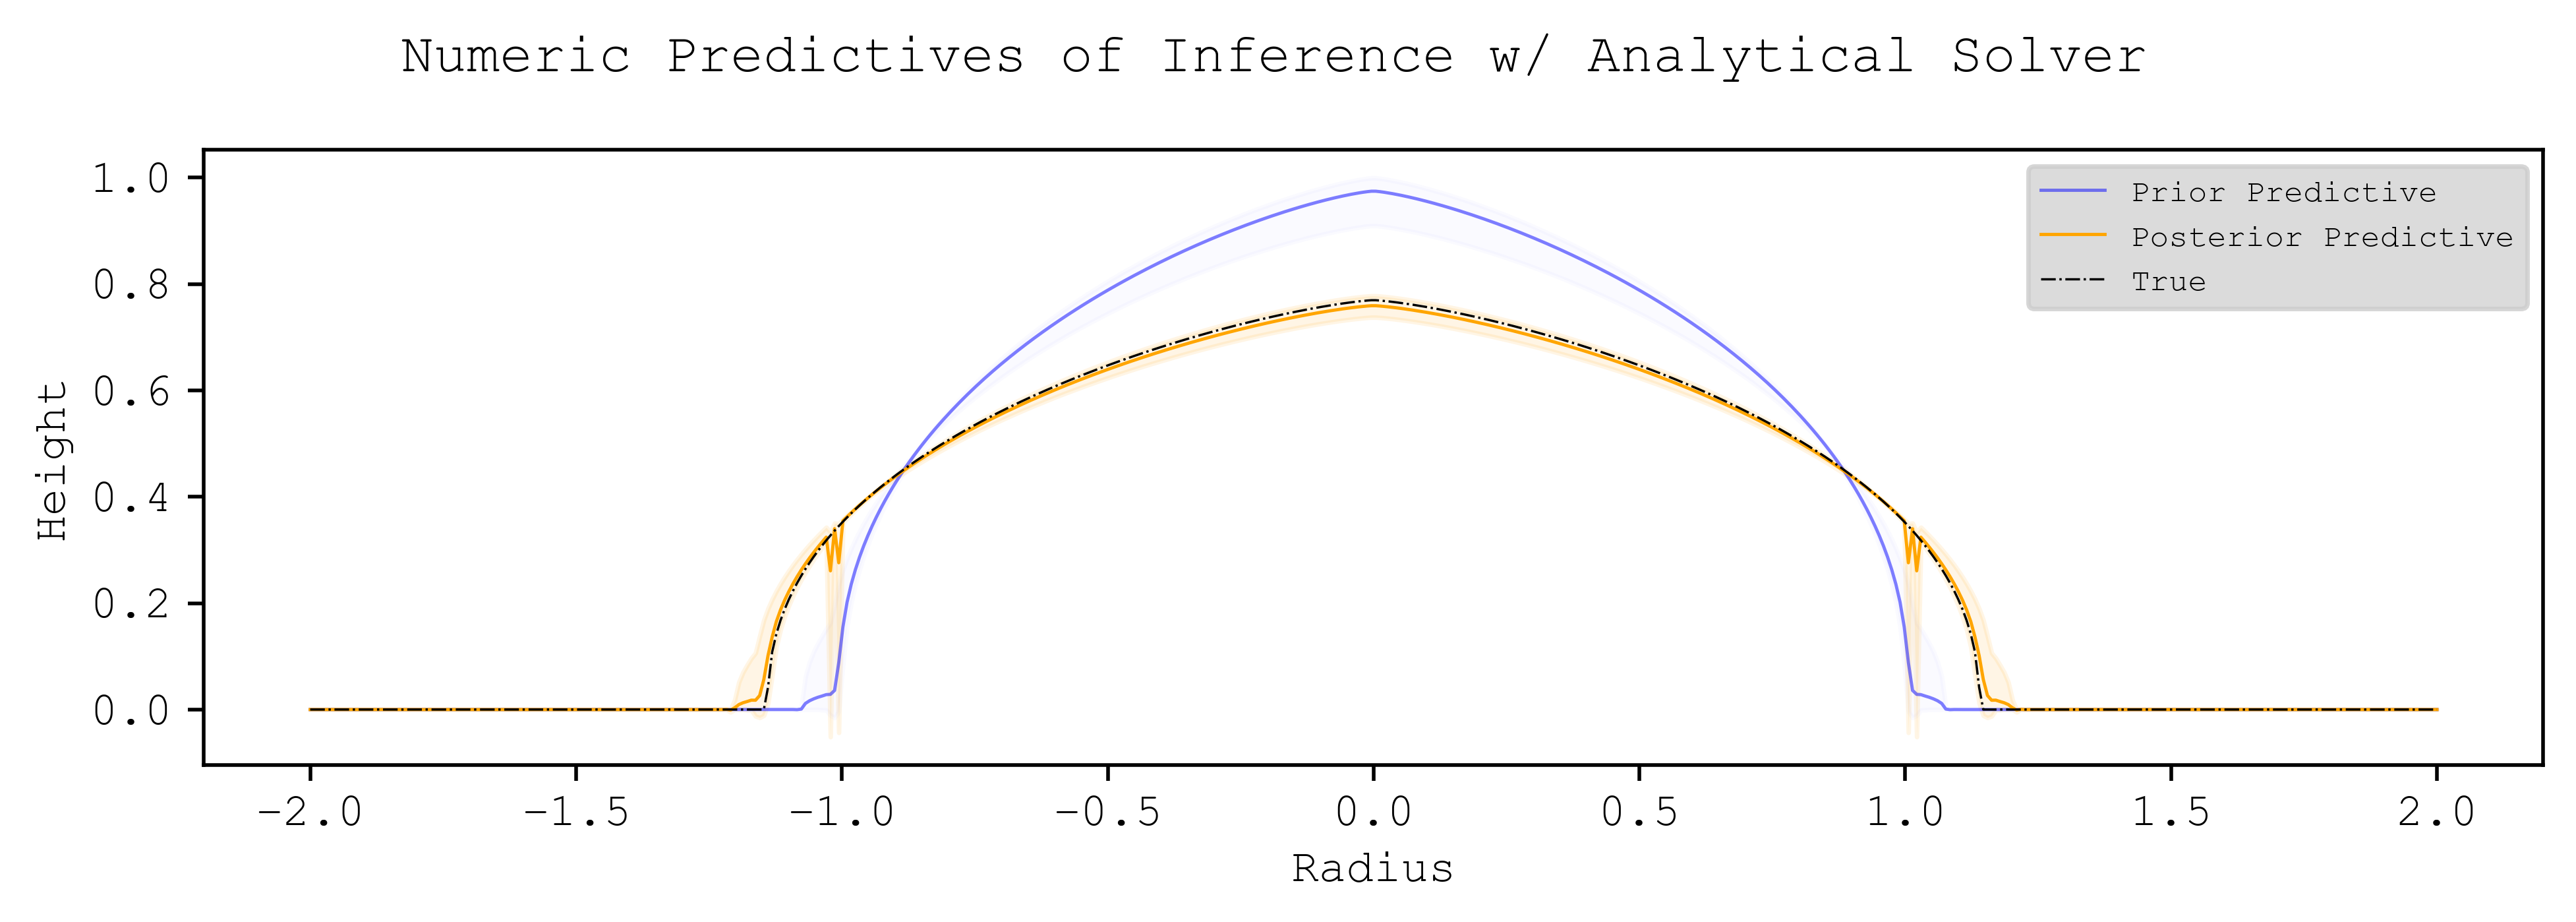

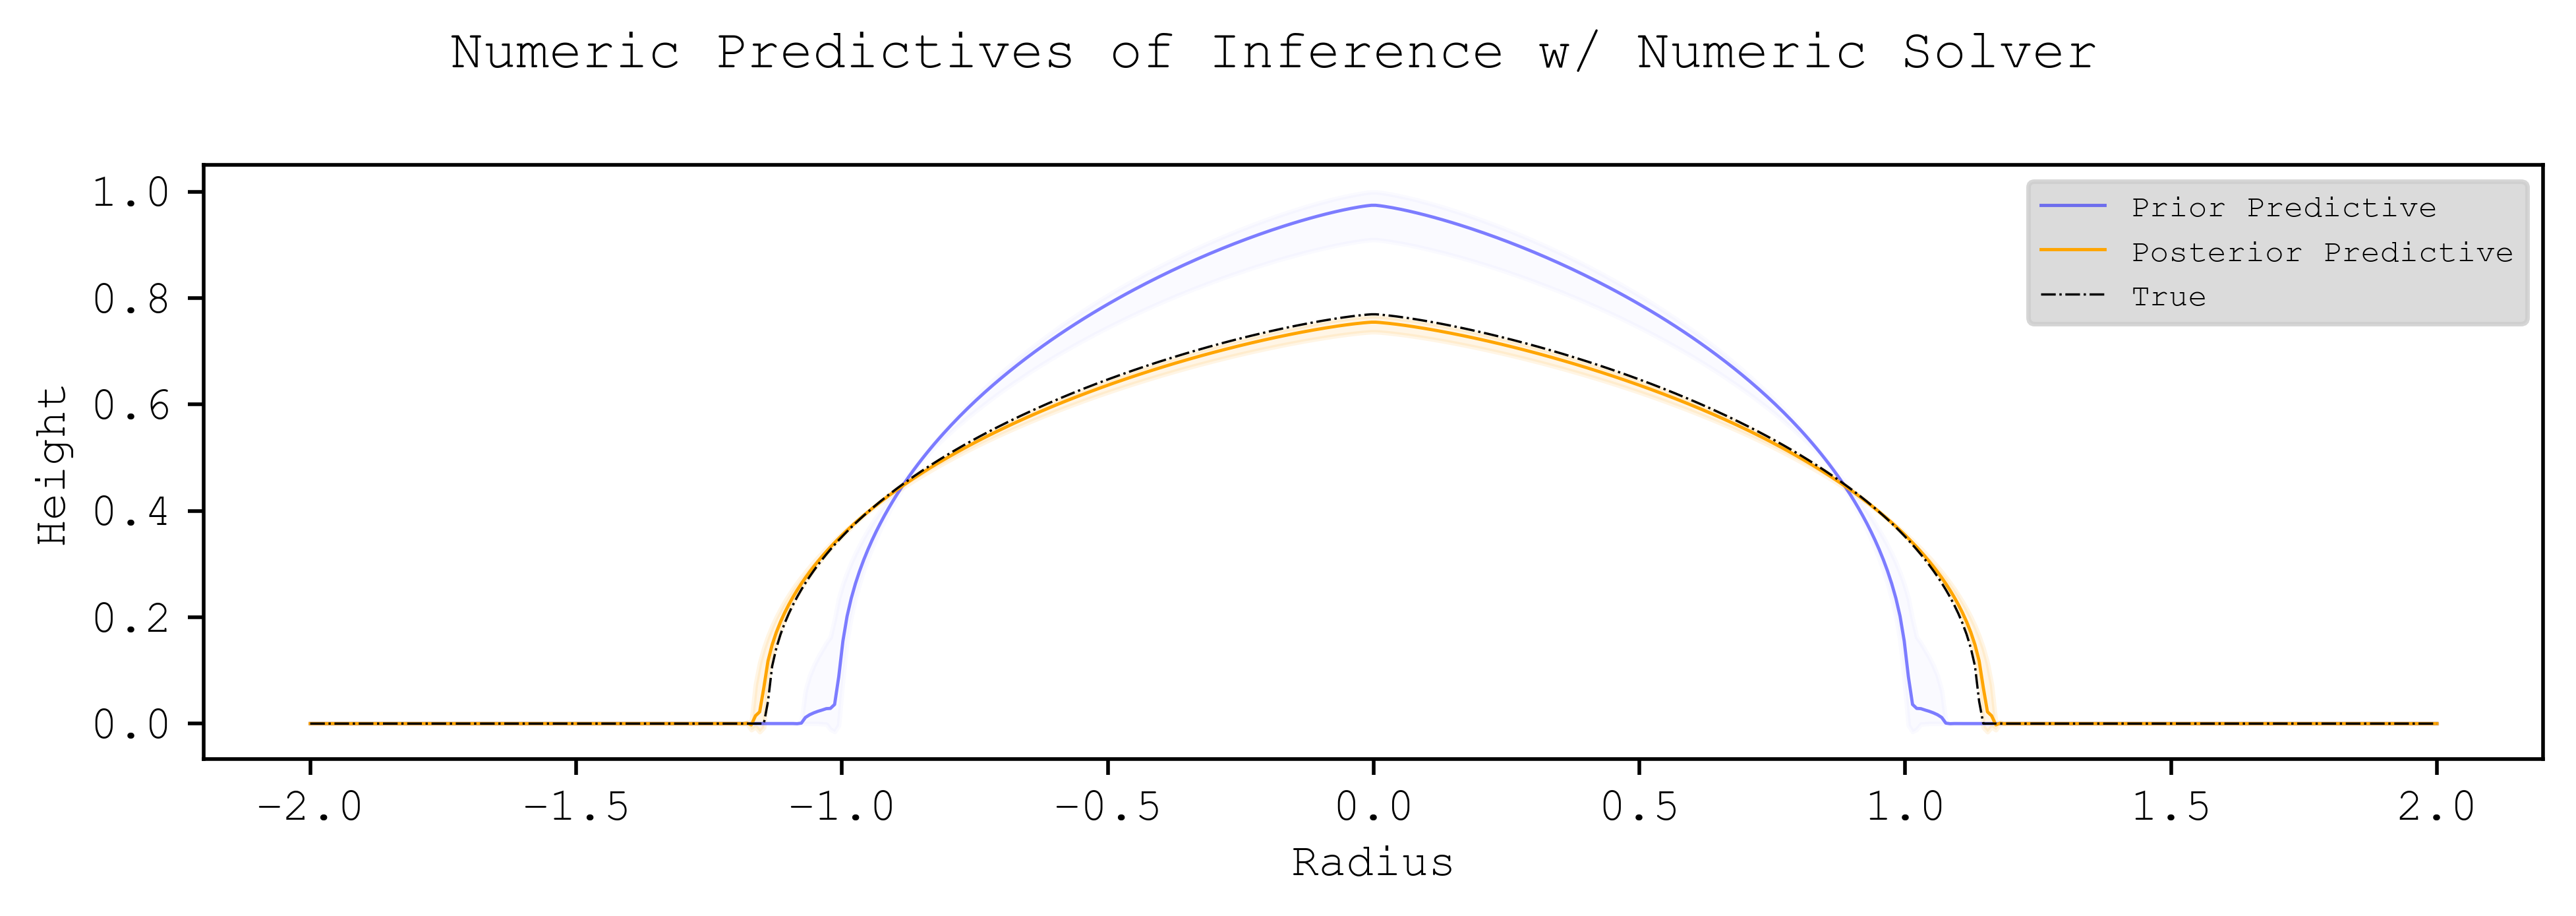

In [28]:
plot_preds(prior_preds, ana_posterior_preds)
plt.suptitle("Numeric Predictives of Inference w/ Analytical Solver")

plot_preds(prior_preds, num_posterior_preds)
plt.suptitle("Numeric Predictives of Inference w/ Numeric Solver")

# References

Halfar, P. (1981). On the dynamics of the ice sheets. Journal of Geophysical Research: Oceans, 86(C11), 11065–11072. https://doi.org/10.1029/JC086iC11p11065
